In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#전에함

In [0]:
!ls models

ls: cannot access 'models': No such file or directory


In [0]:
!ls

adc.json			 model15.h5  model33.h5
agroup_feat.jpg			 model16.h5  model34.h5
bene.jpg			 model17.h5  model35.h5
celeba-dataset.zip		 model18.h5  model36.h5
img_align_celeba		 model19.h5  model37.h5
img_align_celeba.zip		 model1.h5   model38.h5
iu2.jpg				 model20.h5  model39.h5
iu.jpeg				 model21.h5  model3.h5
kaggle.json			 model22.h5  model4.h5
list_attr_celeba.csv		 model23.h5  model5.h5
list_bbox_celeba.csv		 model24.h5  model6.h5
list_eval_partition.csv		 model25.h5  model7.h5
list_landmarks_align_celeba.csv  model26.h5  model8.h5
mmod_human_face_detector.dat	 model27.h5  model9.h5
model0.h5			 model28.h5  models.pkl
model10.h5			 model29.h5  model.weights.best.hdf5
model11.h5			 model2.h5   sample_data
model12.h5			 model30.h5  train_data.pkl
model13.h5			 model31.h5
model14.h5			 model32.h5


In [0]:
#간혹 업로드 코드를 이용해 이미지파일을 올릴 때 에러가 발생하는 경우가 있다. Colaboratory 왼쪽 상단의 업로드를 통해 테스트해볼 이미지 업로드한다.

from google.colab import files

files.upload()

MessageError: ignored

In [0]:
#필요한 라이브러리 추가 다운로드
!pip install cmake

In [0]:
!pip install dlib

In [0]:
#mmod_human_face_detector.dat 업로드. 만약 에러 발생할 경우 Colaboratory 왼쪽 상단의 업로드를 통해 업로드.
files.upload()

NameError: ignored

In [0]:
#방금 추가 설치한 dlib으로 쓸 수 있는 mmod_human_face_detector.dat로 얼굴인식을 한다. (이미 학습되어있는 얼굴 검출기)
import sys
import os
import dlib
import matplotlib.pyplot as plt
import numpy as np
import cv2

def getFaceImages(img):
  faces=[]
  cnn_face_detector = dlib.cnn_face_detection_model_v1('mmod_human_face_detector.dat')
  dets = cnn_face_detector(img, 1)
  image=np.copy(img)
  for k, d in enumerate(dets):
    minx=d.rect.left()-20 
    maxx=d.rect.right()+20 
    miny=d.rect.top()-20 
    maxy=d.rect.bottom()+20 
    cv2.rectangle(image, (minx, miny), (maxx, maxy), (0, 255, 0), 2)
    crop_img = img[ miny:maxy,minx:maxx]
    faces.append(crop_img)
  
  plt.imshow(image)
  plt.xticks([]), plt.yticks([])
  plt.show() 
  
  for i in range(len(dets)):
    plt.imshow(faces[i])
    plt.xticks([]), plt.yticks([])
    plt.show()
    
  
  return faces,dets

In [0]:
#학습한 가중치를 카테고리별로 나눈다. Gender, Expression, Age Group, Wearing, Hair, Other로 큰 카테고리를 만들고 해당 속성들을 할당한다. 
#Input으로 들어온 영상에 해당되는 특징이 있으면 각 카테고리별로 리스트를 만들어서 넣는다.
#print로 preds값을 출력하면 1, 0 각각의 비율을 볼 수 있다. 

import cv2
import numpy as np
from keras.models import load_model

def GetFeatures(faces):
  new_img=[]
  for i in range(len(faces)):
    faces[i]=cv2.resize(faces[i], (64,64))
     
  
  
  faces=np.asarray(faces)
  faces=faces/255
  
  feat_dict={}
  
  model = load_model('model20.h5')#male?
  preds=model.predict(faces)
  gen_list=[]
  for i in range(faces.shape[0]):
    if preds[i][0] >preds[i][1]:
      gen_list.append('Female')
    else:
      gen_list.append('Male')
  
  feat_dict['Gender']=gen_list

 ##############################################
  
  model=load_model('model31.h5')#Smiling?
  preds0=model.predict(faces)
  
  model=load_model('model21.h5')#Mouth_Slightly_Open?
  preds1=model.predict(faces)
#   print(preds1)
      
  
  exp_list=[]
  for i in range(faces.shape[0]):
    if preds0[i][1]>preds0[i][0]:
      exp_list.append('Smiling')
    elif preds1[i][1]>preds1[i][0]:
      exp_list.append('Mouth Slightly Open')
    else:
      exp_list.append('None')
    
      
  feat_dict['Expression']=exp_list
  
 ##############################################
  
  model=load_model('model39.h5')#Young?
  preds0=model.predict(faces)
  
  age_list=[]
  for i in range(faces.shape[0]):
    if preds0[i][1]>preds0[i][0]:
      age_list.append('Young')
    else:
      age_list.append('Not Young')
    
      
  feat_dict['Age Group']=age_list
  
  ##############################################
  
  model=load_model('model8.h5')#Black_Hair?
  preds0=model.predict(faces)
  
  model=load_model('model11.h5')#Brown_Hair?
  preds1=model.predict(faces)
  
  model=load_model('model9.h5')#Blond_Hair?
  preds2=model.predict(faces)
      
  
  
  model=load_model('model17.h5')#Gray_Hair?
  preds3=model.predict(faces)
  
  model=load_model('model4.h5')#Bald?
  preds4=model.predict(faces)
  
  hair_list=[]
  for i in range(faces.shape[0]):
    h=[]
    if preds0[i][1]>preds0[i][0]:
      h.append('Black Hair')
    if preds1[i][1]>preds1[i][0]:
      h.append('Brown Hair')
    if preds2[i][1]>preds2[i][0]:
      h.append('Blond Hair')
    if preds3[i][1]>preds3[i][0]:
      h.append('Gray_Hair')
    if preds4[i][1]>preds4[i][0]:
      h.append('Bald')
    hair_list.append(h)
    
      
  feat_dict['Hair']=hair_list
  
   ##############################################
  
  model=load_model('model15.h5')#Eyeglasses?
  preds0=model.predict(faces)
  
  model=load_model('model35.h5')#Wearing_Hat?
  preds1=model.predict(faces)
  
  model=load_model('model36.h5')#Wearing_Lipstick?
  preds2=model.predict(faces)
      
  
  
  model=load_model('model38.h5')#Wearing_Necktie?
  preds3=model.predict(faces)
 
  
  wear_list=[]
  for i in range(faces.shape[0]):
    w=[]
    if preds0[i][1]>preds0[i][0]:
      w.append('Eyeglasses')
    if preds1[i][1]>preds1[i][0]:
      w.append('Hat')
    if preds2[i][1]>preds2[i][0] and feat_dict['Gender'][i]=="Female":
      w.append('Lipstick')
    if preds3[i][1]>preds3[i][0]:
      w.append('Necktie')
    
    wear_list.append(w)
    
      
  feat_dict['Wearing']=wear_list
  
  ##############################################
  
  model=load_model('model0.h5')#_5_O_Clock_Shadow?
  preds0=model.predict(faces)
  
  model=load_model('model5.h5')#Bangs?
  preds1=model.predict(faces)
  
  model=load_model('model18.h5')#Heavy_Makeup?
  preds2=model.predict(faces)
      
  model=load_model('model22.h5')#Mustache?
  preds3=model.predict(faces)
  
  model=load_model('model24.h5')#No_Beard?
  preds4=model.predict(faces)
  
  model=load_model('model26.h5')#Pale_Skin?
  preds5=model.predict(faces)
  
  model=load_model('model29.h5')#Rosy_Cheeks?
  preds6=model.predict(faces)
  
  model=load_model('model30.h5')#Sideburns?
  preds7=model.predict(faces)
  
  other_list=[]
  for i in range(faces.shape[0]):
    o=[]
    if preds0[i][1]>preds0[i][0] and feat_dict['Gender'][i]=="Male":
      o.append('5 O Clock Shadow')
    if preds1[i][1]>preds1[i][0]:
      o.append('Bangs')
    if preds2[i][1]>preds2[i][0] and feat_dict['Gender'][i]=="Female":
      o.append('Heavy_Makeup')
    if preds3[i][1]>preds3[i][0] and feat_dict['Gender'][i]=="Male":
      o.append('Mustache')
    if preds4[i][1]>preds4[i][0] and feat_dict['Gender'][i]=="Male":
      o.append('No Beard')
    if preds5[i][1]>preds5[i][0]:
      o.append('Pale Skin')
    if preds6[i][1]>preds6[i][0]:
      o.append('Rosy Cheeks')
    if preds7[i][1]>preds7[i][0] and feat_dict['Gender'][i]=="Male":
      o.append('Sideburns')
         
    other_list.append(o)
    
      
  feat_dict['Other']=other_list
  
    
  del model
 
  return feat_dict

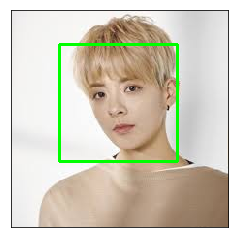

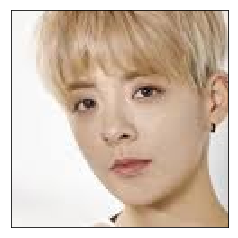

In [0]:
img=dlib.load_rgb_image("female.jpg")
face,det=getFaceImages(img)

In [0]:
face[0].shape

(121, 121, 3)

In [0]:
features=GetFeatures(face)
features
# 다소 시간이 오래 걸립니다.(20분 이상..)

{'Age Group': ['Young'],
 'Expression': ['None'],
 'Gender': ['Female'],
 'Hair': [['Blond Hair']],
 'Other': [['Bangs']],
 'Wearing': [['Hat']]}

In [0]:
#검출된 특징들을 boundingbox처리된 이미지와 함께 한 화면에 보여주는 코드이다. ( 추출된 특징만 확인하고자 한다면 skip해도 됨 )

from random import randint

image=img
white = np.zeros([image.shape[0],3*image.shape[1],3],dtype=np.uint8)
white.fill(255)
image= np.hstack( (image,white) )
white = np.zeros([150,image.shape[1],3],dtype=np.uint8)
white.fill(255)
image= np.vstack( (image,white) )


for i in range(len(det)):
  x0=img.shape[1]+((i*img.shape[1])//3)
  y0=20
  
  red=randint(0, 255)
  green=randint(0, 255)
  blue=randint(0, 255)
  
  minx=det[i].rect.left()-30 if det[i].rect.left()-30 > 0 else 0
  maxx=det[i].rect.right()+30 if det[i].rect.right()-30 > 0 else 0
  miny=det[i].rect.top()-30 if det[i].rect.top()-30 > 0 else 0
  maxy=det[i].rect.bottom()+30 if det[i].rect.bottom()-30 > 0 else 0
  cv2.rectangle(image, (minx, miny), (maxx, maxy), (red, green, blue), 2)
  label="Person "+str(i+1)
  
  
  cv2.putText(image,label,(minx+10,maxy+20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (red, green, blue), 2)
 
  cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (red, green, blue), 2)
  y0=y0+30
  
  label="Gender: "+features['Gender'][i]
  cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
  y0=y0+30
  
  
  label="Age Group: "+features['Age Group'][i]
  cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
  y0=y0+30
  
  label='Expression :'+features['Expression'][i]
  cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
  y0=y0+30
  
  lab_list=features['Hair'][i]
  label='Hair :'
  
  if len(lab_list)==0:
    label=label+"None"
    cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
    y0=y0+20
    
  else:
    cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
    y0=y0+20
    for j in range(len(lab_list)):
      cv2.putText(image,lab_list[j],(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
      y0=y0+20
      
  y0=y0+10
  lab_list=features['Wearing'][i]
  label='Wearing :'
  
  
  if len(lab_list)==0:
    label=label+"None"
    cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
    y0=y0+20
    
  else:
    cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
    y0=y0+20
    for j in range(len(lab_list)):
      cv2.putText(image,lab_list[j],(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
      y0=y0+20
  
  
  y0=y0+10
  lab_list=features['Other'][i]
  label='Other :'
  
  
  if len(lab_list)==0:
    label=label+"None"
    cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
    y0=y0+20
    
  else:
    cv2.putText(image,label,(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
    y0=y0+20
    for j in range(len(lab_list)):
      cv2.putText(image,lab_list[j],(x0,y0),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (red, green, blue), 1)
      y0=y0+20

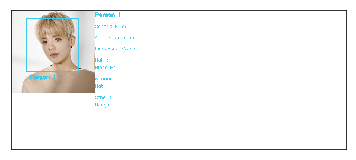

In [0]:
plt.imshow(image)
plt.xticks([]),plt.yticks([])
plt.show()

In [0]:
dlib.save_image(image,'agroup_feat.jpg')

In [0]:
#결과 화면 이미지로 로컬에 다운
from google.colab import files
files.download('agroup_feat.jpg')